# Build neighbourhood VDJ feature space

In [1]:
import numpy as np
import seaborn as sns
import os
import pandas as pd
import scanpy as sc
import dandelion as ddl
ddl.logging.print_header()

dandelion==0.3.1.dev21 pandas==1.4.4 numpy==1.19.4 matplotlib==3.5.2 networkx==2.8.8 scipy==1.5.3


In [2]:
import matplotlib.pyplot as plt

In [3]:
# set working directory
os.chdir('/lustre/scratch117/cellgen/team205/cs42/VDJ_collab_manuscript/')

In [4]:
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.4.6 numpy==1.19.4 scipy==1.5.3 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [5]:
# figure directory
fig_path = '/home/jovyan/mount/gdrive/VDJ_collab/plots_output/chenqu_jhub/'
sc.settings.figdir = fig_path

In [9]:
pip list

Package                       Version              Location
----------------------------- -------------------- ----------------------
adjustText                    0.7.3
airr                          1.3.1
aniso8601                     9.0.1
anndata                       0.8.0
annoy                         1.17.0
antlr-denter                  1.3.1
antlr4-python3-runtime        4.9.3
appdirs                       1.4.4
argon2-cffi                   20.1.0
async-generator               1.10
attrs                         21.2.0
automata-lib                  7.0.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.1
backports.zoneinfo            0.2.1
bbknn                         1.3.12
beautifulsoup4                4.10.0
biopython                     1.79
bioservices                   1.8.2
bleach                        3.2.1
boto3                         1.7.84
botocore                      1.10.84
cached-property               1.5.1
cattrs                        1.

# Load data

In [6]:
nhood_adata = sc.read('write/DP_nhood_adata_pseudotime_vdj_11012023.h5ad')

In [7]:
nhood_adata_gex = sc.read('write/DP_nhood_adata_pseudotime_gex_11012023.h5ad')

/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
nhood_adata.obs['pseudotime_nhood_gex'] = nhood_adata_gex.obs['pseudotime_nhood_gex']

# monocle3

In [9]:
nhood_adata

AnnData object with n_obs × n_vars = 1348 × 160
    obs: 'anno_lvl_2_final_clean', 'anno_lvl_2_final_clean_fraction', 'cell_count', 'rootcell', 'terminal_states', 'pseudotime_nhood_vdj', 'prob_CD8+T_nhood_vdj', 'prob_CD4+T_nhood_vdj', 'pseudotime_nhood_gex'
    uns: 'anno_lvl_2_final_clean_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'pbs'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

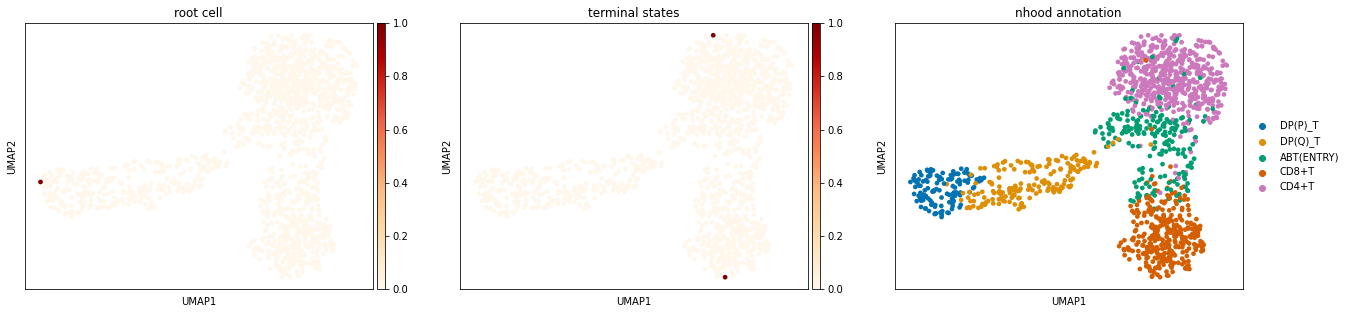

In [10]:
sc.pl.umap(nhood_adata,color=['rootcell','terminal_states','anno_lvl_2_final_clean'],
           title=['root cell','terminal states','nhood annotation'],color_map='OrRd')

In [11]:
%load_ext rpy2.ipython

In [12]:
#data prep for monocle3. need to subset the obs as rpy2 doesn't handle categoricals well now apparently
obs = nhood_adata.obs[['anno_lvl_2_final_clean','anno_lvl_2_final_clean_fraction']]
pca = nhood_adata.obsm['X_umap']
iroot = nhood_adata.obs_names[nhood_adata.obs['rootcell']==1]

In [13]:
#obs.to_csv('csv/nhood_adata_obs.csv')
#np.savetxt('csv/nhood_adata_pca.csv', pca, delimiter=',')

R[write to console]: Loading required package: Biobase

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort,

[1] ‘0.2.3.0’
  |======================================================================| 100%


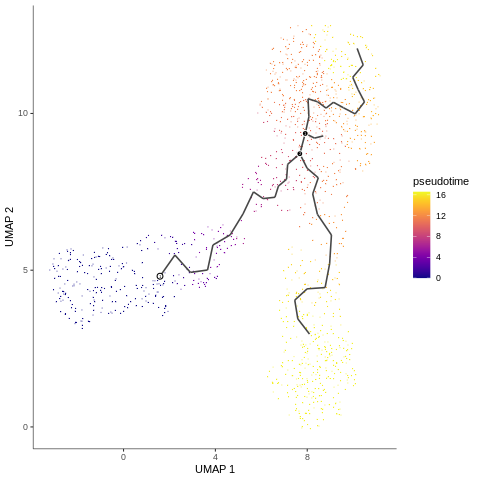

In [14]:
%%R -i obs -i pca -i iroot -o pseudotime 
        
library(monocle3)
print(packageVersion("monocle3"))

#create basic monocle object
X = matrix(0,nrow=1,ncol=dim(obs)[1])
mono = new_cell_data_set(X, cell_metadata=obs)

#hack in the UMAP into the appropriate object slot
umap = as.matrix(pca)
rownames(umap) = rownames(obs)
reducedDims(mono) = SimpleList(UMAP=umap)

#identify pseudotime graph structure, compute pseudotime
mono = cluster_cells(mono, reduction_method='UMAP')
mono = learn_graph(mono)
mono = order_cells(mono, root_cells=iroot)
pseudotime = mono@principal_graph_aux[['UMAP']]$pseudotime

#plot the various branchings R-side as this doesn't lend itself nicely to python porting
plot_cells(mono,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

In [15]:
nhood_adata.obs['monocle3_pseudotime'] = pseudotime

# DPT

In [16]:
nhood_adata.uns['iroot'] = np.flatnonzero(nhood_adata.obs['rootcell'] == 1)[0]

In [17]:
sc.tl.dpt(nhood_adata)

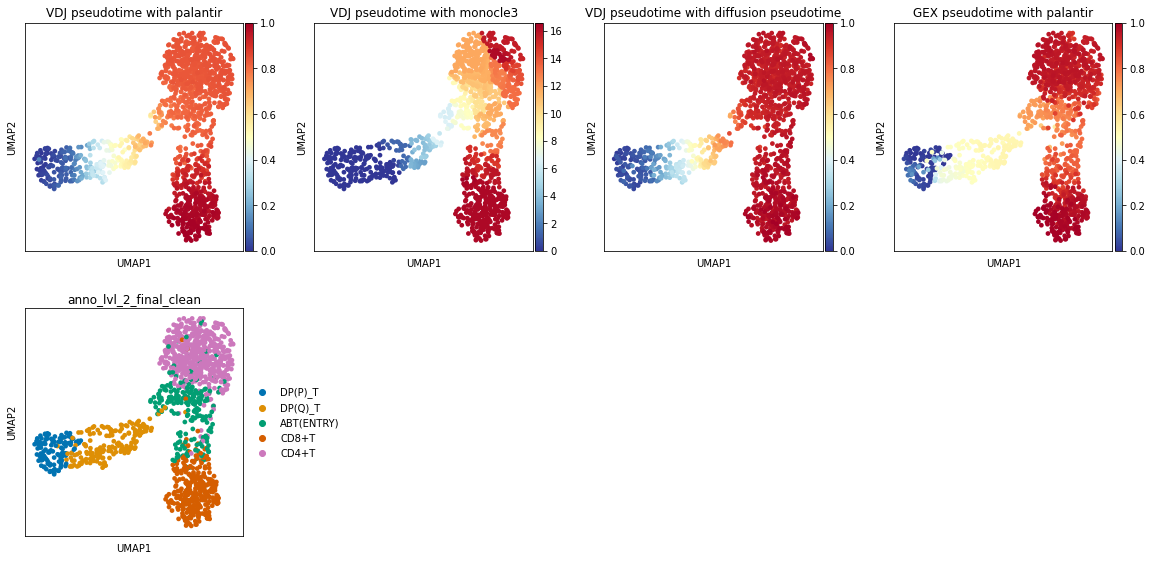

In [18]:
plt.rcParams["figure.figsize"] = [4,4.35]
sc.pl.umap(nhood_adata, color=['pseudotime_nhood_vdj','monocle3_pseudotime','dpt_pseudotime','pseudotime_nhood_gex','anno_lvl_2_final_clean'], 
           title=['VDJ pseudotime with palantir','VDJ pseudotime with monocle3','VDJ pseudotime with diffusion pseudotime','GEX pseudotime with palantir'],
           ncols=4,cmap = 'RdYlBu_r',save='trajectory_comparison.pdf')

# TCR pseudotime gives better DP(Q) ordering

In [19]:
# load TCR list by location - lists in github folder metadata/TCR_genes
TCR_list_by_loc_dict = {}
for chain in ['TRAV','TRAJ']:
    path = 'gene_list/'+chain+'_list_by_location.csv'
    TCR_list_by_loc_dict[chain] = list(pd.read_csv(path, header=None)[0])

In [26]:
chain = 'TRAV' # 'TRAV' or 'TRAJ'

In [27]:
# only leave nhoods with at least 90% cells being DP(Q)_T
DP = nhood_adata[np.array(nhood_adata.obs['anno_lvl_2_final_clean']=='DP(Q)_T') & np.array(nhood_adata.obs['anno_lvl_2_final_clean_fraction']>0.9)]
# only look at TRAV/TRAJ
TRAV_TRAJ = pd.DataFrame(data = DP[:,DP.var_names.str.startswith(chain)].X, index = DP.obs_names, columns = DP.var_names[DP.var_names.str.startswith(chain)])

In [28]:
# encode TRAV genomic locations numerically (i.e. from 1 to 46)
gene_loc = pd.DataFrame(index = TRAV_TRAJ.columns, columns = ['location'], dtype='int')
for gene in TRAV_TRAJ.columns:
    gene_loc.loc[gene, 'location'] = TCR_list_by_loc_dict[chain].index(gene)

In [29]:
# calculate average TRAV geenomic location for each neighbourhood
df_plot = pd.DataFrame({'loc':TRAV_TRAJ.dot(gene_loc['location']),
                       't_tcr_order_palantir': DP.obs['pseudotime_nhood_vdj'].rank(),
                        't_tcr_order_monocle':DP.obs['monocle3_pseudotime'].rank(),
                        't_tcr_order_dpt':DP.obs['dpt_pseudotime'].rank(),
                        't_gex_order':DP.obs['pseudotime_nhood_gex'].rank()})

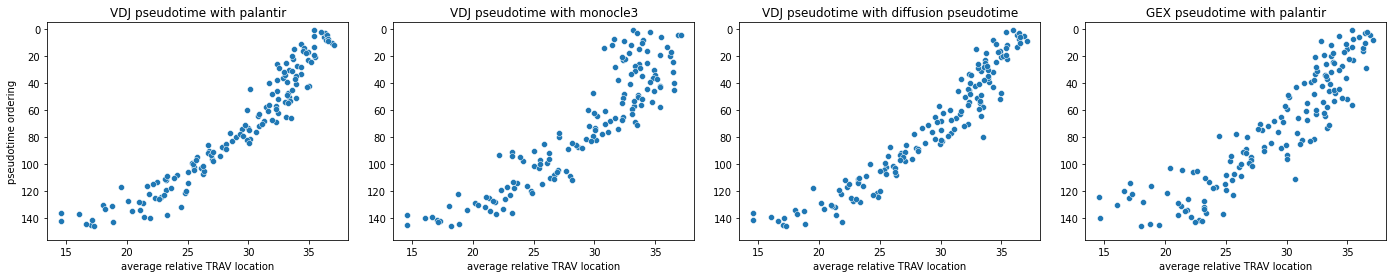

In [30]:
fig, ax = plt.subplots(1,4,figsize=(24,4))
plt.subplots_adjust(wspace=0.15,hspace=0.35)

sns.scatterplot(data = df_plot, x = 'loc', y = 't_tcr_order_palantir',ax=ax[0]) 
ax[0].set_title('VDJ pseudotime with palantir')
ax[0].set_ylabel('pseudotime ordering')
ax[0].set_xlabel('average relative ' + chain + ' location')
ax[0].set_ylim(df_plot.shape[0]+10,-5)

sns.scatterplot(data = df_plot, x = 'loc', y = 't_tcr_order_monocle',ax=ax[1]) 
ax[1].set_title('VDJ pseudotime with monocle3')
ax[1].set_ylabel('')
ax[1].set_xlabel('average relative ' + chain + ' location')
ax[1].set_ylim(df_plot.shape[0]+10,-5)

sns.scatterplot(data = df_plot, x = 'loc', y = 't_tcr_order_dpt',ax=ax[2]) 
ax[2].set_title('VDJ pseudotime with diffusion pseudotime')
ax[2].set_ylabel('')
ax[2].set_xlabel('average relative ' + chain + ' location')
ax[2].set_ylim(df_plot.shape[0]+10,-5)

sns.scatterplot(data = df_plot, x = 'loc', y = 't_gex_order',ax=ax[3])
ax[3].set_title('GEX pseudotime with palantir')
ax[3].set_ylabel('')
ax[3].set_xlabel('average relative ' + chain + ' location')
ax[3].set_ylim(df_plot.shape[0]+10,-5)


plt.savefig(fig_path+chain+'_location_pseudotime_trajectory_comparison.pdf',bbox_inches='tight');

In [25]:
import scipy
print(chain)
for method in df_plot.columns[1:]:
    print(method, scipy.stats.pearsonr(df_plot['loc'],df_plot[method]))

TRAJ
t_tcr_order_palantir (0.9252817174474762, 1.6809566720282565e-62)
t_tcr_order_monocle (0.9011979233673842, 3.798607394523233e-54)
t_tcr_order_dpt (0.9308809778491273, 7.552246759686095e-65)
t_gex_order (0.8941390129497183, 4.212089792269586e-52)


In [31]:
print(chain)
for method in df_plot.columns[1:]:
    print(method, scipy.stats.pearsonr(df_plot['loc'],df_plot[method]))

TRAV
t_tcr_order_palantir (-0.9521917964026926, 4.8391396852352315e-76)
t_tcr_order_monocle (-0.9072744298560697, 4.9174921672443765e-56)
t_tcr_order_dpt (-0.9495709545936566, 2.054843664191208e-74)
t_gex_order (-0.900222599864192, 7.433638053416253e-54)
